## SVM for image classification
[readmore](https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01)

In [121]:
import pandas as pd
import os

from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
import skimage

import numpy as np
import matplotlib.pyplot as plt

import joblib
from tqdm import tqdm
from collections import Counter
from PIL import Image 

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix

from pretty_confusion_matrix import pp_matrix

%matplotlib inline

### Function for resize the images

In [85]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in tqdm(os.listdir(current_path)):
                if file[-3:] in {'jpg', 'png'}:
                    img = Image.open(os.path.join(current_path, file))
                    img_rgb = img.convert('RGB') # convert to RGB

                    im = np.asarray(img_rgb)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[-1])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [86]:
repo_name = 'Respiratory_Disease_Classification'
cwd_path = os.getcwd()
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split/train"
src = os.listdir(train_dir)[1:]

In [89]:
base_name_train = 'spectrogram_train'
width = 80
include = src

# resize_all(src=train_dir,pklname=base_name, width=width, include=src)

In [97]:
base_name_val = 'spectrogram_val'
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split/val"

resize_all(src=train_dir,pklname=base_name, width=width, include=src)

health_1


100%|██████████| 324/324 [00:07<00:00, 44.05it/s]


health_0


100%|██████████| 674/674 [00:15<00:00, 43.58it/s]


In [98]:
data_train = joblib.load(f'{base_name_train}_{width}x{width}px.pkl')
data_val = joblib.load(f'{base_name_val}_{width}x{width}px.pkl')
 
print('number of training samples: ', len(data_train['data']))
print('number of validation samples: ', len(data_val['data']))

print('keys: ', list(data_train.keys()))
print('description: ', data_train['description'])
print('image shape: ', data_train['data'][0].shape)
print('labels:', np.unique(data_train['label']))
 
print("Training data",Counter(data_train['label']))
print("Validation data", Counter(data_val['label']))

number of training samples:  2491
number of validation samples:  998
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['0' '1']
Training data Counter({'0': 1508, '1': 983})
Validation data Counter({'0': 674, '1': 324})


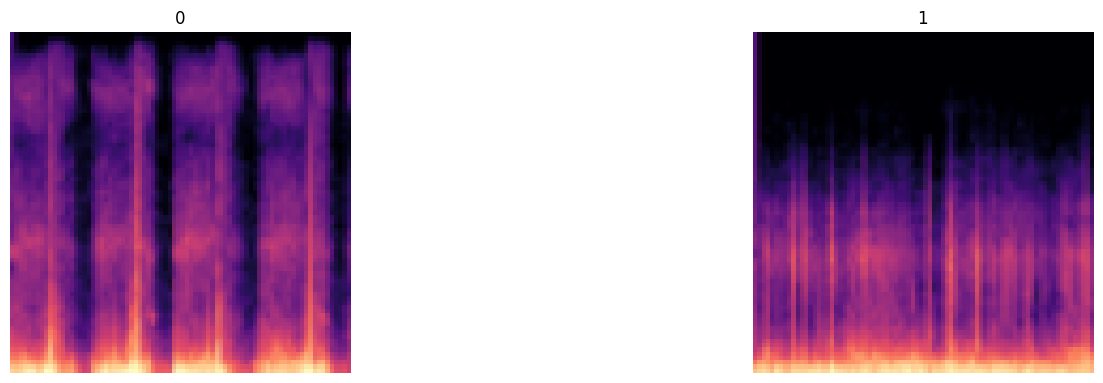

In [114]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data_train['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data_train['label'].index(label)
     
    ax.imshow(data_train['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [115]:
# Define Train-Test, use validation data for testing
X_train = np.array(data_train['data'])
y_train = np.array(data_train['label'])
X_test = np.array(data_val['data'])
y_test = np.array(data_val['label'])

# X_train, X_test, y_train, y_test = train_test_split(
#     X, 
#     y, 
#     test_size=0.2, 
#     shuffle=True,
#     random_state=42,
# )

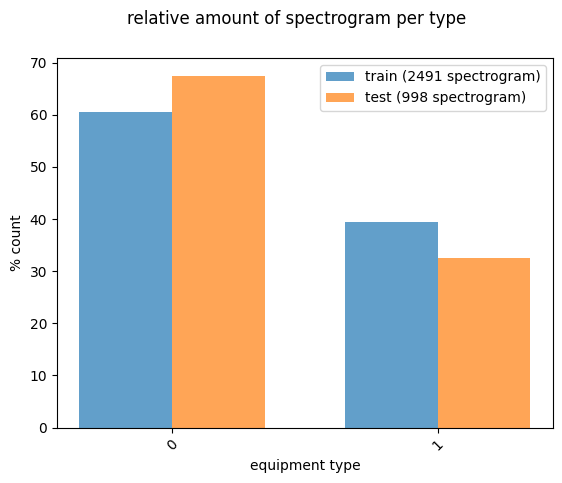

In [102]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of spectrogram per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} spectrogram)'.format(len(y_train)), 
    'test ({0} spectrogram)'.format(len(y_test))
]);

HOG-SVM example

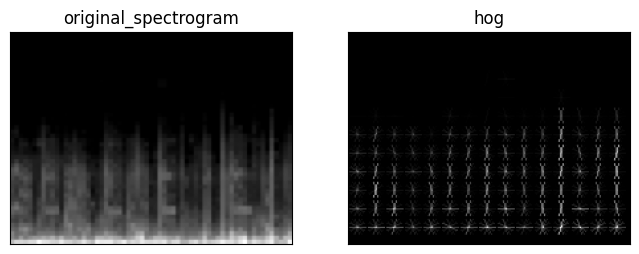

In [103]:
img_path = "/Users/liki/neuefische/Respiratory_Disease_Classification/data/images/90-10_noSplit/test/health_0/0_f1_3464.png"

spec = imread(img_path, as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
spec = rescale(spec, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
spec_hog, spec_hog_img = hog(
    spec, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('original_spectrogram')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [104]:
print('number of pixels: ', spec.shape[0] * spec.shape[1])
print('number of hog features: ', spec_hog.shape[0])

number of pixels:  34080
number of hog features:  5040


HOG Transformers
- Color images to gray scale
- Calculate HOGs
- Scale the data

In [105]:
# RGB2Gray

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [106]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2491, 576)


## Model Training

In [107]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

## Testing

In [116]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

## Evaluation

In [117]:
y_pred = sgd_clf.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  74.14829659318637


### Confusion Matrix

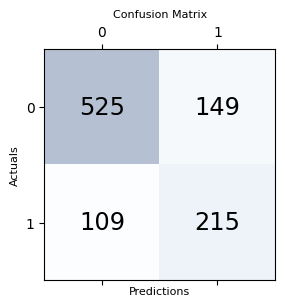

In [130]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()

## Pipeline

In [131]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  74.14829659318637


## Grid Search

In [133]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [134]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [135]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl')

['hog_sgd_model.pkl']

In [142]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

In [140]:
# the highscore during the search
grid_res.best_score_

0.8631102025430241

In [143]:
print(grid_res.best_params_)

{'hogify__cells_per_block': (3, 3), 'hogify__orientations': 8, 'hogify__pixels_per_cell': (8, 8)}


In [145]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  78.3567134268537


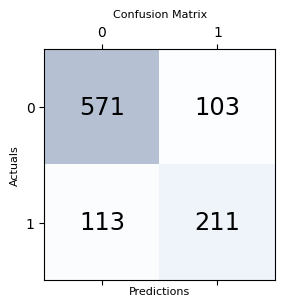

In [146]:
cm_gridS = confusion_matrix(y_test, best_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm_gridS, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm_gridS.shape[0]):
    for j in range(cm_gridS.shape[1]):
        ax.text(x=j, y=i,s=cm_gridS[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()
